In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=False,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
class log_UAR(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

#             score = recall_score(y_pred=pred, y_true=true, average='macro')
            confmat = confusion_matrix(y_pred=pred, y_true=true)
            logs['recall0'] = confmat[0,0]/np.sum(confmat[0,:])
            logs['recall1'] = confmat[1,1]/np.sum(confmat[1,:])
            logs['recall2'] = confmat[2,2]/np.sum(confmat[2,:])
            logs['UAR'] = np.mean([logs['recall0'],logs['recall1'],logs['recall2']])

In [5]:
fold_dir = '/home/prio/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/home/prio/heart_sound/models/'
log_dir = '/home/prio/heart_sound/logs/'

##### Load Model ######
load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5'
# lr = 0.00001
lr = 0.006028585143146318
num_dense1 = 1458 #34,120,167,239,1239,650,788,422,598
num_dense2 = 179 #121,
epochs = 45
batch_size = 256
# dropout_rate = 0.
trainable = False
addweights = True

In [6]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [7]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
#     lr = args['lr']
#     num_dense1 = args['num_dense1']
#     num_dense2 = args['num_dense2']
    dropout_rate = args['dropout_rate']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str(args.values())
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_UAR(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
#     print("History : %s" % history.history)
    loss = history.history['val_loss']
#     print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': loss[-1], 'status': STATUS_OK}

In [8]:
space = {
#     'lr' : 10 ** hp.uniform('lr',-6,-2),
#     'num_dense1' : 1000 + hp.randint('num_dense1',1500),
#     'num_dense2' : 80 + hp.randint('num_dense2',140),
    'dropout_rate' : hp.uniform('dropout_rate',0,1)
}

In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=20)
print('best:', best)

args {'dropout_rate': 0.30982027729404316}
Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
6s - loss: 1.3192 - acc: 0.3700 - val_loss: 1.1119 - val_acc: 0.3183
Epoch 2/45
5s - loss: 1.1097 - acc: 0.4136 - val_loss: 1.1144 - val_acc: 0.3035
Epoch 3/45
5s - loss: 1.0721 - acc: 0.4279 - val_loss: 1.1098 - val_acc: 0.3231
Epoch 4/45
5s - loss: 1.0589 - acc: 0.4360 - val_loss: 1.1099 - val_acc: 0.3145
Epoch 5/45
5s - loss: 1.0364 - acc: 0.4508 - val_loss: 1.1170 - val_acc: 0.2910
Epoch 6/45
5s - loss: 1.0272 - acc: 0.4595 - val_loss: 1.1113 - val_acc: 0.3171
Epoch 7/45
5s - loss: 1.0069 - acc: 0.4802 - val_loss: 1.1282 - val_acc: 0.3115
Epoch 8/45
5s - loss: 0.9970 - acc: 0.4800 - val_loss: 1.1260 - val_acc: 0.3251
Epoch 9/45
5s - loss: 0.9810 - acc: 0.4956 - val_loss: 1.1280 - val_acc: 0.3171
Epoch 10/45
5s - loss: 0.9786 - acc: 0.4871 - val_loss: 1.1252 - val_acc: 0.3254
Epoch 11/45
5s - loss:

5s - loss: 1.0258 - acc: 0.4576 - val_loss: 1.1270 - val_acc: 0.3040
Epoch 7/45
5s - loss: 1.0118 - acc: 0.4717 - val_loss: 1.1300 - val_acc: 0.3072
Epoch 8/45
5s - loss: 1.0049 - acc: 0.4759 - val_loss: 1.1311 - val_acc: 0.3176
Epoch 9/45
5s - loss: 0.9999 - acc: 0.4816 - val_loss: 1.1236 - val_acc: 0.3306
Epoch 10/45
5s - loss: 0.9820 - acc: 0.4935 - val_loss: 1.1293 - val_acc: 0.3275
Epoch 11/45
5s - loss: 0.9691 - acc: 0.4966 - val_loss: 1.1334 - val_acc: 0.3191
Epoch 12/45
5s - loss: 0.9619 - acc: 0.5017 - val_loss: 1.1335 - val_acc: 0.3208
Epoch 13/45
5s - loss: 0.9455 - acc: 0.5190 - val_loss: 1.1396 - val_acc: 0.3197
Epoch 14/45
5s - loss: 0.9464 - acc: 0.5185 - val_loss: 1.1334 - val_acc: 0.3273
Epoch 15/45
5s - loss: 0.9351 - acc: 0.5200 - val_loss: 1.1299 - val_acc: 0.3379
Epoch 16/45
5s - loss: 0.9211 - acc: 0.5315 - val_loss: 1.1285 - val_acc: 0.3362
Epoch 17/45
5s - loss: 0.9137 - acc: 0.5385 - val_loss: 1.1352 - val_acc: 0.3326
Epoch 18/45
5s - loss: 0.9100 - acc: 0.5398

5s - loss: 1.1080 - acc: 0.3401 - val_loss: 1.0988 - val_acc: 0.3036
Epoch 15/45
5s - loss: 1.1065 - acc: 0.3244 - val_loss: 1.0987 - val_acc: 0.3120
Epoch 16/45
5s - loss: 1.1060 - acc: 0.3266 - val_loss: 1.0991 - val_acc: 0.2406
Epoch 17/45
5s - loss: 1.1088 - acc: 0.3194 - val_loss: 1.0991 - val_acc: 0.2239
Epoch 18/45
5s - loss: 1.1033 - acc: 0.3148 - val_loss: 1.0991 - val_acc: 0.2093
Epoch 19/45
5s - loss: 1.1066 - acc: 0.3267 - val_loss: 1.0998 - val_acc: 0.1974
Epoch 20/45
5s - loss: 1.1051 - acc: 0.3236 - val_loss: 1.0981 - val_acc: 0.4229
Epoch 21/45
5s - loss: 1.1047 - acc: 0.3353 - val_loss: 1.0991 - val_acc: 0.3001
Epoch 22/45
5s - loss: 1.1027 - acc: 0.3218 - val_loss: 1.0984 - val_acc: 0.3726
Epoch 23/45
5s - loss: 1.1043 - acc: 0.3196 - val_loss: 1.0988 - val_acc: 0.2927
Epoch 24/45
5s - loss: 1.1004 - acc: 0.3251 - val_loss: 1.0983 - val_acc: 0.3753
Epoch 25/45
5s - loss: 1.1009 - acc: 0.3227 - val_loss: 1.0985 - val_acc: 0.3227
Epoch 26/45
5s - loss: 1.1005 - acc: 0.3

5s - loss: 1.0555 - acc: 0.4036 - val_loss: 1.1053 - val_acc: 0.2750
Epoch 23/45
5s - loss: 1.0518 - acc: 0.4006 - val_loss: 1.1055 - val_acc: 0.2786
Epoch 24/45
5s - loss: 1.0477 - acc: 0.4023 - val_loss: 1.1066 - val_acc: 0.2791
Epoch 25/45
5s - loss: 1.0445 - acc: 0.4087 - val_loss: 1.1061 - val_acc: 0.2790
Epoch 26/45
5s - loss: 1.0453 - acc: 0.4080 - val_loss: 1.1049 - val_acc: 0.2817
Epoch 27/45
5s - loss: 1.0400 - acc: 0.4065 - val_loss: 1.1043 - val_acc: 0.2912
Epoch 28/45
5s - loss: 1.0363 - acc: 0.4146 - val_loss: 1.1069 - val_acc: 0.2875
Epoch 29/45
5s - loss: 1.0304 - acc: 0.4211 - val_loss: 1.1110 - val_acc: 0.2844
Epoch 30/45
5s - loss: 1.0288 - acc: 0.4201 - val_loss: 1.1101 - val_acc: 0.2926
Epoch 31/45
5s - loss: 1.0242 - acc: 0.4324 - val_loss: 1.1141 - val_acc: 0.2846
Epoch 32/45
5s - loss: 1.0221 - acc: 0.4322 - val_loss: 1.1131 - val_acc: 0.2841
Epoch 33/45
5s - loss: 1.0228 - acc: 0.4332 - val_loss: 1.1150 - val_acc: 0.2841
Epoch 34/45
5s - loss: 1.0255 - acc: 0.4

5s - loss: 1.0951 - acc: 0.3308 - val_loss: 1.1019 - val_acc: 0.2066
Epoch 31/45
5s - loss: 1.0950 - acc: 0.3412 - val_loss: 1.1032 - val_acc: 0.2207
Epoch 32/45
5s - loss: 1.0942 - acc: 0.3322 - val_loss: 1.1019 - val_acc: 0.2214
Epoch 33/45
5s - loss: 1.0924 - acc: 0.3472 - val_loss: 1.1028 - val_acc: 0.2136
Epoch 34/45
5s - loss: 1.0922 - acc: 0.3575 - val_loss: 1.1031 - val_acc: 0.2165
Epoch 35/45
5s - loss: 1.0920 - acc: 0.3537 - val_loss: 1.1022 - val_acc: 0.2231
Epoch 36/45
5s - loss: 1.0929 - acc: 0.3343 - val_loss: 1.1021 - val_acc: 0.2190
Epoch 37/45
5s - loss: 1.0888 - acc: 0.3415 - val_loss: 1.1028 - val_acc: 0.2188
Epoch 38/45
5s - loss: 1.0850 - acc: 0.3422 - val_loss: 1.1025 - val_acc: 0.2180
Epoch 39/45
5s - loss: 1.0893 - acc: 0.3533 - val_loss: 1.1029 - val_acc: 0.2185
Epoch 40/45
5s - loss: 1.0860 - acc: 0.3468 - val_loss: 1.1028 - val_acc: 0.2277
Epoch 41/45
5s - loss: 1.0867 - acc: 0.3548 - val_loss: 1.1031 - val_acc: 0.2282
Epoch 42/45
5s - loss: 1.0849 - acc: 0.3

5s - loss: 1.1087 - acc: 0.3023 - val_loss: 1.0999 - val_acc: 0.1929
Epoch 39/45
5s - loss: 1.1079 - acc: 0.3016 - val_loss: 1.1001 - val_acc: 0.1929
Epoch 40/45
5s - loss: 1.1091 - acc: 0.3037 - val_loss: 1.1005 - val_acc: 0.1929
Epoch 41/45
5s - loss: 1.1076 - acc: 0.2968 - val_loss: 1.1005 - val_acc: 0.1933
Epoch 42/45
5s - loss: 1.1069 - acc: 0.3041 - val_loss: 1.1005 - val_acc: 0.1929
Epoch 43/45
5s - loss: 1.1076 - acc: 0.2877 - val_loss: 1.1005 - val_acc: 0.1929
Epoch 44/45
5s - loss: 1.1071 - acc: 0.3056 - val_loss: 1.1008 - val_acc: 0.1931
Epoch 45/45
5s - loss: 1.1062 - acc: 0.2985 - val_loss: 1.1009 - val_acc: 0.1929
args {'dropout_rate': 0.4152428485607985}
Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4304 - acc: 0.3735 - val_loss: 1.1013 - val_acc: 0.3488
Epoch 2/45
5s - loss: 1.1527 - acc: 0.3849 - val_loss: 1.1070 - val_acc: 0.2939
Epoch 3/45
5s - loss: 1.1058

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2372 - acc: 0.3882 - val_loss: 1.0993 - val_acc: 0.3891
Epoch 2/45
5s - loss: 1.0603 - acc: 0.4511 - val_loss: 1.1458 - val_acc: 0.2832
Epoch 3/45
5s - loss: 1.0126 - acc: 0.4771 - val_loss: 1.1569 - val_acc: 0.3197
Epoch 4/45
5s - loss: 0.9835 - acc: 0.4977 - val_loss: 1.1325 - val_acc: 0.3534
Epoch 5/45
5s - loss: 0.9673 - acc: 0.5113 - val_loss: 1.1356 - val_acc: 0.3537
Epoch 6/45
5s - loss: 0.9446 - acc: 0.5302 - val_loss: 1.1510 - val_acc: 0.3333
Epoch 7/45
5s - loss: 0.9229 - acc: 0.5363 - val_loss: 1.1583 - val_acc: 0.3421
Epoch 8/45
5s - loss: 0.8982 - acc: 0.5541 - val_loss: 1.1589 - val_acc: 0.3411
Epoch 9/45
5s - loss: 0.8840 - acc: 0.5683 - val_loss: 1.1687 - val_acc: 0.3369
Epoch 10/45
5s - loss: 0.8697 - acc: 0.5717 - val_loss: 1.1973 - val_acc: 0.3205
Epoch 11/45
5s - loss: 0.8548 - acc: 0.5811 - val_loss: 1.1704 - 

5s - loss: 1.0624 - acc: 0.4016 - val_loss: 1.1107 - val_acc: 0.2682
Epoch 8/45
5s - loss: 1.0549 - acc: 0.4172 - val_loss: 1.1096 - val_acc: 0.2774
Epoch 9/45
5s - loss: 1.0481 - acc: 0.4271 - val_loss: 1.1144 - val_acc: 0.2711
Epoch 10/45
5s - loss: 1.0343 - acc: 0.4288 - val_loss: 1.1161 - val_acc: 0.2636
Epoch 11/45
5s - loss: 1.0371 - acc: 0.4313 - val_loss: 1.1158 - val_acc: 0.2764
Epoch 12/45
5s - loss: 1.0240 - acc: 0.4385 - val_loss: 1.1158 - val_acc: 0.2786
Epoch 13/45
5s - loss: 1.0181 - acc: 0.4460 - val_loss: 1.1131 - val_acc: 0.2888
Epoch 14/45
5s - loss: 1.0105 - acc: 0.4544 - val_loss: 1.1161 - val_acc: 0.2846
Epoch 15/45
5s - loss: 1.0037 - acc: 0.4586 - val_loss: 1.1157 - val_acc: 0.2881
Epoch 16/45
5s - loss: 0.9928 - acc: 0.4704 - val_loss: 1.1220 - val_acc: 0.2955
Epoch 17/45
5s - loss: 0.9904 - acc: 0.4712 - val_loss: 1.1164 - val_acc: 0.3004
Epoch 18/45
5s - loss: 0.9815 - acc: 0.4811 - val_loss: 1.1226 - val_acc: 0.2979
Epoch 19/45
5s - loss: 0.9823 - acc: 0.474

5s - loss: 1.0407 - acc: 0.4312 - val_loss: 1.1079 - val_acc: 0.2880
Epoch 16/45
5s - loss: 1.0429 - acc: 0.4214 - val_loss: 1.1064 - val_acc: 0.2887
Epoch 17/45
5s - loss: 1.0341 - acc: 0.4394 - val_loss: 1.1079 - val_acc: 0.2832
Epoch 18/45
5s - loss: 1.0247 - acc: 0.4340 - val_loss: 1.1100 - val_acc: 0.2885
Epoch 19/45
5s - loss: 1.0263 - acc: 0.4339 - val_loss: 1.1083 - val_acc: 0.2973
Epoch 20/45
5s - loss: 1.0215 - acc: 0.4422 - val_loss: 1.1083 - val_acc: 0.2956
Epoch 21/45
5s - loss: 1.0152 - acc: 0.4584 - val_loss: 1.1137 - val_acc: 0.2967
Epoch 22/45
5s - loss: 1.0100 - acc: 0.4513 - val_loss: 1.1158 - val_acc: 0.2968
Epoch 23/45
5s - loss: 1.0087 - acc: 0.4556 - val_loss: 1.1156 - val_acc: 0.2987
Epoch 24/45
5s - loss: 1.0083 - acc: 0.4551 - val_loss: 1.1126 - val_acc: 0.3011
Epoch 25/45
5s - loss: 0.9933 - acc: 0.4602 - val_loss: 1.1163 - val_acc: 0.3060
Epoch 26/45
5s - loss: 0.9905 - acc: 0.4663 - val_loss: 1.1189 - val_acc: 0.3050
Epoch 27/45
5s - loss: 0.9917 - acc: 0.4

5s - loss: 1.0277 - acc: 0.4341 - val_loss: 1.1172 - val_acc: 0.2854
Epoch 24/45
5s - loss: 1.0251 - acc: 0.4277 - val_loss: 1.1162 - val_acc: 0.2824
Epoch 25/45
5s - loss: 1.0269 - acc: 0.4328 - val_loss: 1.1189 - val_acc: 0.2880
Epoch 26/45
5s - loss: 1.0256 - acc: 0.4361 - val_loss: 1.1204 - val_acc: 0.2846
Epoch 27/45
5s - loss: 1.0132 - acc: 0.4428 - val_loss: 1.1199 - val_acc: 0.2944
Epoch 28/45
5s - loss: 1.0154 - acc: 0.4459 - val_loss: 1.1191 - val_acc: 0.2927
Epoch 29/45
5s - loss: 1.0115 - acc: 0.4550 - val_loss: 1.1265 - val_acc: 0.2847
Epoch 30/45
5s - loss: 1.0072 - acc: 0.4477 - val_loss: 1.1261 - val_acc: 0.2795
Epoch 31/45
5s - loss: 1.0030 - acc: 0.4602 - val_loss: 1.1271 - val_acc: 0.2839
Epoch 32/45
5s - loss: 1.0025 - acc: 0.4569 - val_loss: 1.1252 - val_acc: 0.2880
Epoch 33/45
5s - loss: 0.9969 - acc: 0.4623 - val_loss: 1.1276 - val_acc: 0.2934
Epoch 34/45
5s - loss: 0.9950 - acc: 0.4633 - val_loss: 1.1302 - val_acc: 0.2895
Epoch 35/45
5s - loss: 0.9942 - acc: 0.4

In [10]:
trials.results

[{'loss': 0.5885119140148163, 'status': 'ok'},
 {'loss': 0.6127125918865204, 'status': 'ok'},
 {'loss': 0.5919897854328156, 'status': 'ok'},
 {'loss': 0.6134864091873169, 'status': 'ok'},
 {'loss': 0.5277125835418701, 'status': 'ok'},
 {'loss': 0.6070918440818787, 'status': 'ok'},
 {'loss': 0.61424320936203, 'status': 'ok'},
 {'loss': 0.5842517018318176, 'status': 'ok'},
 {'loss': 0.6498724520206451, 'status': 'ok'},
 {'loss': 0.6398639380931854, 'status': 'ok'},
 {'loss': 0.6473214328289032, 'status': 'ok'},
 {'loss': 0.6014966070652008, 'status': 'ok'},
 {'loss': 0.6033333241939545, 'status': 'ok'},
 {'loss': 0.5728996694087982, 'status': 'ok'},
 {'loss': 0.609073132276535, 'status': 'ok'},
 {'loss': 0.6132908165454865, 'status': 'ok'},
 {'loss': 0.5749830007553101, 'status': 'ok'},
 {'loss': 0.6331547498703003, 'status': 'ok'},
 {'loss': 0.6341411471366882, 'status': 'ok'},
 {'loss': 0.6315986514091492, 'status': 'ok'}]

In [15]:
it=0
UAR = np.zeros(len(trials))
params = np.zeros((len(trials),4))
for objects in trials.trials:
                  UAR[it] = 1 - objects['result']['loss'] 
#                   params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
#                   params[it,1] = objects['misc']['vals']['num_dense1'][0]
#                   params[it,2] = objects['misc']['vals']['num_dense2'][0]
                  params[it,3] = objects['misc']['vals']['dropout_rate'][0]
                  it+=1

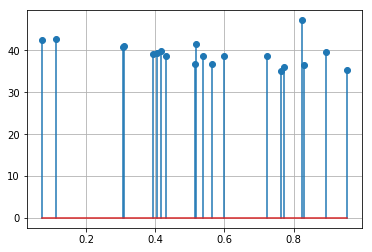

In [20]:
import matplotlib.pyplot as plt
plt.stem(params[:,3],UAR[:]*100,)
# plt.colorbar()
# plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
1258 +200

In [ ]:
10 ** best['lr']

In [ ]:
200 + best['num_dense1']

In [ ]:
20 + best['num_dense2']

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_pred=[0, 2, 1, 0, 0, 1],y_true=[0, 1, 2, 0, 1, 2])[0,0]/sum(confusion_matrix(y_pred=[0, 2, 1, 0, 0, 1],y_true=[0, 1, 2, 0, 1, 2])[0,:])